# Predicting Future Crime Rates with Facebook Prophet 

## 78753

In [1]:
# importing necessary libraries and configurations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import itertools

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

from fbprophet import Prophet
from fbprophet.plot import plot_plotly
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import logging
import warnings

warnings.filterwarnings("ignore")
logging.getLogger("fbprophet").setLevel(logging.ERROR)
plt.style.use("seaborn")
%matplotlib inline

In [2]:
# loading datasets
df = pd.read_csv("df_53.csv")

In [3]:
# data cleaning and indexing

drop = ["zip_code", "latitude", "longitude"]

df.drop(drop, axis=1, inplace=True)
df.occurred_date_time = df.occurred_date_time.astype("datetime64")
df.set_index(["occurred_date_time"], inplace=True)
df.sort_index(inplace=True)

THEFT                             17277
BURGLARY OF VEHICLE               16026
FAMILY DISTURBANCE                14910
CRIMINAL MISCHIEF                  9571
THEFT BY SHOPLIFTING               7707
ASSAULT W/INJURY-FAM/DATE VIOL     7269
BURGLARY OF RESIDENCE              6115
DWI                                5086
DISTURBANCE - OTHER                4835
CUSTODY ARREST TRAFFIC WARR        4352
Name: highest_offense_description, dtype: int64

THEFT                             0.095195
BURGLARY OF VEHICLE               0.088302
FAMILY DISTURBANCE                0.082153
CRIMINAL MISCHIEF                 0.052735
THEFT BY SHOPLIFTING              0.042465
ASSAULT W/INJURY-FAM/DATE VIOL    0.040052
BURGLARY OF RESIDENCE             0.033693
DWI                               0.028023
DISTURBANCE - OTHER               0.026640
CUSTODY ARREST TRAFFIC WARR       0.023979
Name: highest_offense_description, dtype: float64

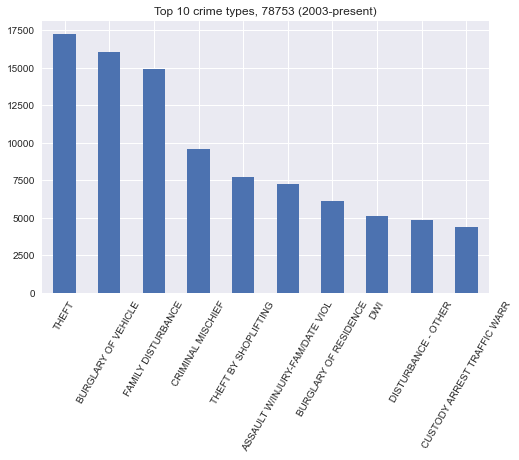

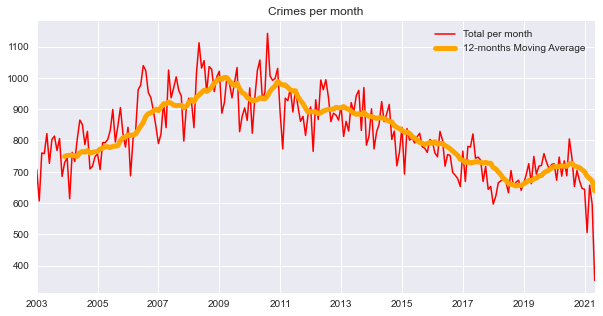

In [4]:
 2# Create and show dataframe for crime rates by type

display(df.highest_offense_description.value_counts().head(10))
display(df.highest_offense_description.value_counts(normalize=True).head(10))

# Visualizing the top 10 crime types

df.highest_offense_description.value_counts().head(10).plot.bar(
    title="Top 10 crime types, 78753 (2003-present)", figsize=(8, 5), rot=60
)
plt.show()

# Using resample 'M' and rolling window 12

plt.figure(figsize=(10, 5))
df.resample("M").size().plot(color="red", linewidth=1.5, label="Total per month")
df.resample("M").size().rolling(window=12).mean().plot(
    color="orange", linewidth=5, label="12-months Moving Average"
)
plt.title("Crimes per month")
plt.xlabel("")
plt.legend()
plt.show()

In [5]:
display(df["highest_offense_description"].value_counts().head(10))

df2 = df.query(
    'highest_offense_description == ["THEFT", "AUTO THEFT", "THEFT BY SHOPLIFTING", "ASSAULT WITH INJURY", "BURGLARY OF VEHICLE", "DWI", "CRIMINAL TRESPASS"]'
)

monthly = pd.DataFrame(
    df2[df2["highest_offense_description"] == "THEFT"].resample("M").size()
)
monthly.columns = ["THEFT"]

for i in df2["highest_offense_description"].unique():
    monthly[i] = pd.DataFrame(
        df2[df2["highest_offense_description"] == i].resample("M").size()
    )

monthly["TOTAL"] = monthly.sum(axis=1)

crimeType = monthly.columns

display(monthly.tail())

THEFT                             17277
BURGLARY OF VEHICLE               16026
FAMILY DISTURBANCE                14910
CRIMINAL MISCHIEF                  9571
THEFT BY SHOPLIFTING               7707
ASSAULT W/INJURY-FAM/DATE VIOL     7269
BURGLARY OF RESIDENCE              6115
DWI                                5086
DISTURBANCE - OTHER                4835
CUSTODY ARREST TRAFFIC WARR        4352
Name: highest_offense_description, dtype: int64

THEFT  BURGLARY OF VEHICLE  ASSAULT WITH INJURY  \
occurred_date_time                                                    
2021-01-31             44                   20                   12   
2021-02-28             28                   20                   16   
2021-03-31             42                   36                   19   
2021-04-30             29                   16                   24   
2021-05-31             17                    9                   13   

                    AUTO THEFT  DWI  THEFT BY SHOPLIFTING  CRIMINAL TRESPASS  \
occurred_date_time                                                             
2021-01-31                  29   18                    20                 11   
2021-02-28                  19    8                    14                 12   
2021-03-31                  30   14                    34                 13   
2021-04-30                  18   12                     9                 10   
2021-05-31                  18    5                    13                  8   

                    TOTAL  
occurred_date_time         
2021-01-31            154  
2021-02-28            117  
2021-03-31            188  
2021-04-30            118  
2021-05-31             83

-----------------------------------------------------------------
Calculating and plotting time series with moving average included
-----------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

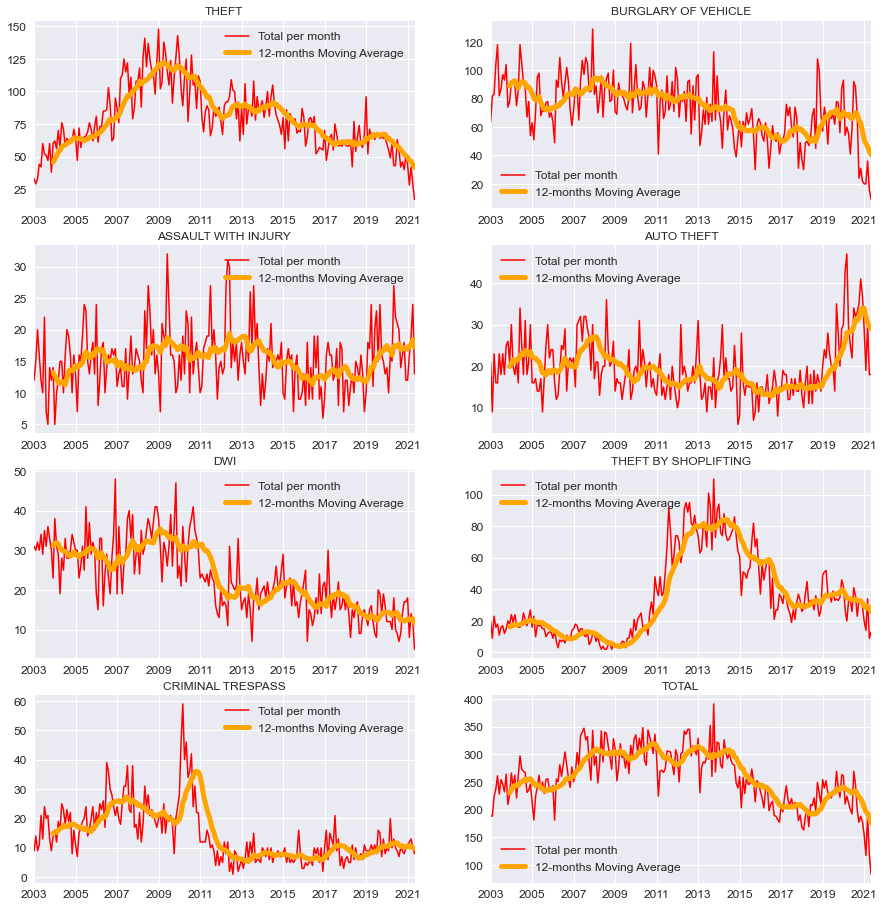

-----------------------------------------------
 Calculating and visualizing the 1st difference
-----------------------------------------------


<Figure size 432x288 with 0 Axes>

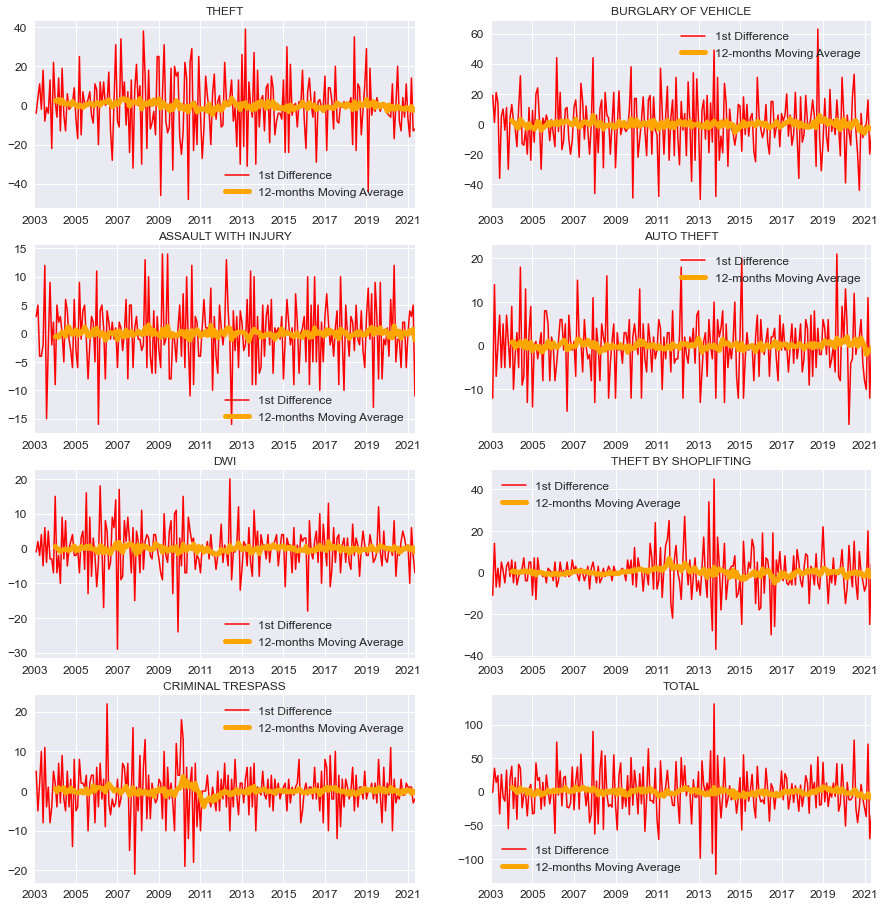

In [6]:
print("-----------------------------------------------------------------")
print("Calculating and plotting time series with moving average included")
print("-----------------------------------------------------------------")
plt.figure(1)
plt.figure(figsize=(15, 20))

i = 521
for eachCrime in crimeType:
    plt.subplot(i)
    monthly[eachCrime].plot(color="red", linewidth=1.5, label="Total per month")
    monthly[eachCrime].rolling(window=12).mean().plot(
        color="orange", linewidth=5, label="12-months Moving Average"
    )
    plt.title(eachCrime, fontsize=12)
    plt.xlabel("")
    plt.legend(prop={"size": 12})
    plt.tick_params(labelsize=12)
    i = i + 1
plt.show()

print("-----------------------------------------------")
print(" Calculating and visualizing the 1st difference")
print("-----------------------------------------------")
# Initiate the figure and define size
plt.figure(1)
plt.figure(figsize=(15, 20))

# Using a for loop to plot each type of crime with a moving average
i = 521
for eachCrime in crimeType:
    plt.subplot(i)
    monthly[eachCrime].diff().plot(color="red", linewidth=1.5, label="1st Difference")
    monthly[eachCrime].rolling(window=12).mean().diff().plot(
        color="orange", linewidth=5, label="12-months Moving Average"
    )
    plt.title(eachCrime, fontsize=12)
    plt.xlabel("")
    plt.legend(prop={"size": 12})
    plt.tick_params(labelsize=12)
    i = i + 1

In [7]:
# Create a data frame with the 1st difference

montlhy_1stDiff = monthly.diff().dropna()

# Create a data frame with the results of the ADF test for each type

adfullerResults = pd.DataFrame(
    columns=crimeType,
    index=["ADF", "Critical Value 1%", "Critical Value 5%", "p-value"],
)
for eachType in crimeType:
    adf = adfuller(montlhy_1stDiff[eachType])
    adfullerResults[eachType] = (
        "{:.4f}".format(adf[0]),
        "{:.4f}".format(adf[4]["1%"]),
        "{:.4f}".format(adf[4]["5%"]),
        "{:.4f}".format(adf[1]),
    )
adfullerResults

THEFT BURGLARY OF VEHICLE ASSAULT WITH INJURY AUTO THEFT  \
ADF                -3.7021             -6.8256             -8.1949    -8.1067   
Critical Value 1%  -3.4623             -3.4620             -3.4623    -3.4616   
Critical Value 5%  -2.8756             -2.8755             -2.8756    -2.8753   
p-value             0.0041              0.0000              0.0000     0.0000   

                       DWI THEFT BY SHOPLIFTING CRIMINAL TRESPASS    TOTAL  
ADF                -7.8088              -3.3017          -24.5523  -3.7026  
Critical Value 1%  -3.4619              -3.4622           -3.4606  -3.4623  
Critical Value 5%  -2.8754              -2.8755           -2.8748  -2.8756  
p-value             0.0000               0.0148            0.0000   0.0041

'THEFT'

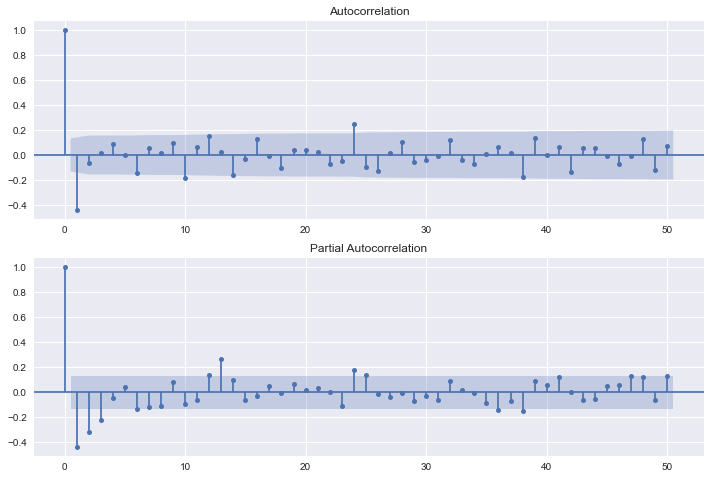

In [8]:
display(montlhy_1stDiff[crimeType[0]].name)
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(montlhy_1stDiff[crimeType[0]], lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(montlhy_1stDiff[crimeType[0]], lags=50, ax=ax2)

In [9]:
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print("Examples of parameter combinations for Seasonal ARIMA...")
print("SARIMAX: {} x {}".format(pdq[1], seasonal_pdq[1]))
print("SARIMAX: {} x {}".format(pdq[1], seasonal_pdq[2]))
print("SARIMAX: {} x {}".format(pdq[2], seasonal_pdq[3]))
print("SARIMAX: {} x {}".format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [10]:
# Creating a function to use a pipeline
def myArima(crimeTypeSeries):
    print("Training for:", crimeTypeSeries.name)
    lowestAIC = 999999999
    bestOrder = 0
    bestSeasonal_order = 0
    i = 0
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(
                    crimeTypeSeries, order=param, seasonal_order=param_seasonal
                )
                results = mod.fit()
                newAIC = results.aic
                if newAIC < lowestAIC:
                    lowestAIC = newAIC
                    bestOrder = param
                    bestSeasonal_order = param_seasonal
                i = i + 1
                print("\r", "Calculating: {:.0f}%".format(i / 64 * 100), end="")
            except:
                i = i + 1
                print("\r", "Calculating: {:.0f}%".format(i / 64 * 100), end="")
                continue
    print("\nBest parameters: SARIMA{}x{}12".format(param, param_seasonal))
    mod = sm.tsa.statespace.SARIMAX(
        crimeTypeSeries, order=bestOrder, seasonal_order=bestSeasonal_order
    )
    results = mod.fit()
    results.plot_diagnostics(figsize=(15, 12))
    plt.show()
    pred = results.get_prediction(start=168, end=230, dynamic=False)
    pred_ci = pred.conf_int()
    pred_ci.head()
    plt.figure(figsize=(15, 6))
    ax = crimeTypeSeries.plot(label="observed")
    plt.title("Actual and Forecast", fontsize=12)
    pred.predicted_mean.plot(
        ax=ax, label="One-step ahead forecast", color="red", alpha=0.7, lw=4
    )
    ax.fill_between(
        pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color="r", alpha=0.3
    )
    ax.set_xlabel("Years")
    ax.set_ylabel("Number of crime")
    plt.legend()
    plt.show()
    return results

Training for: THEFT
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


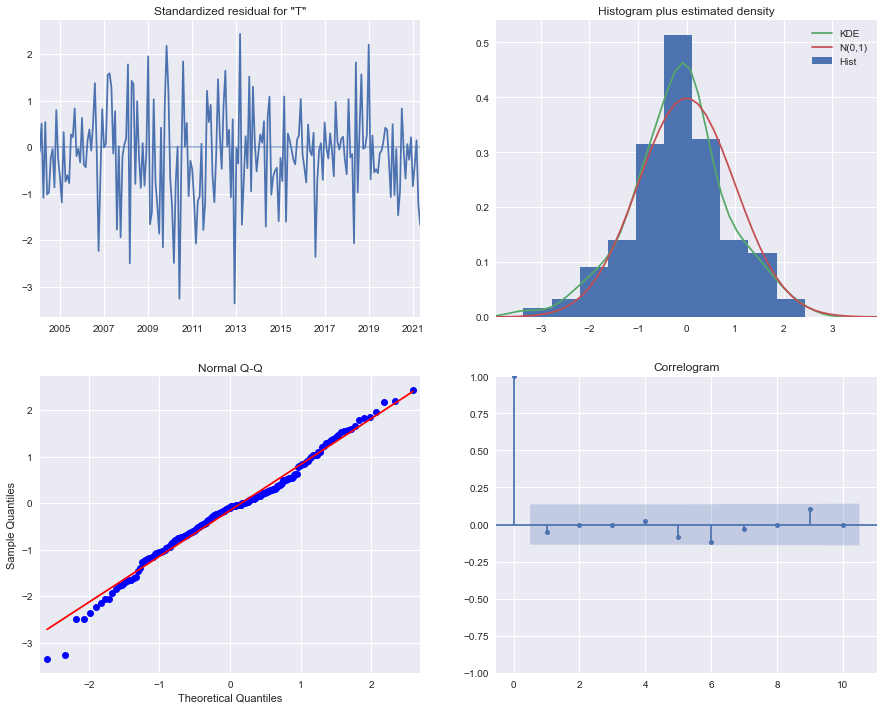

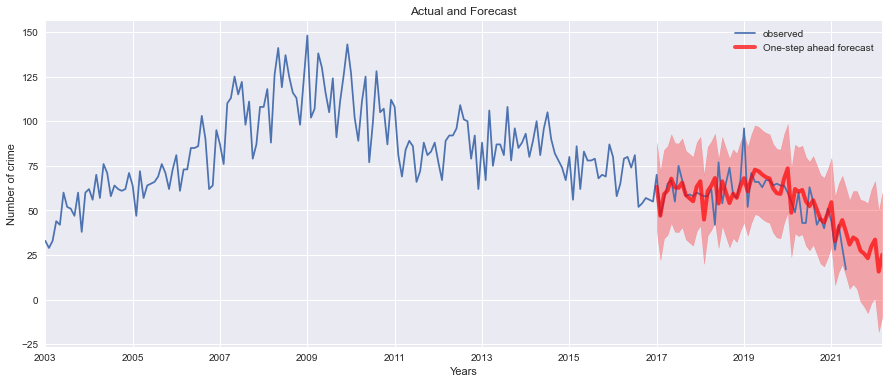

Training for: BURGLARY OF VEHICLE
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


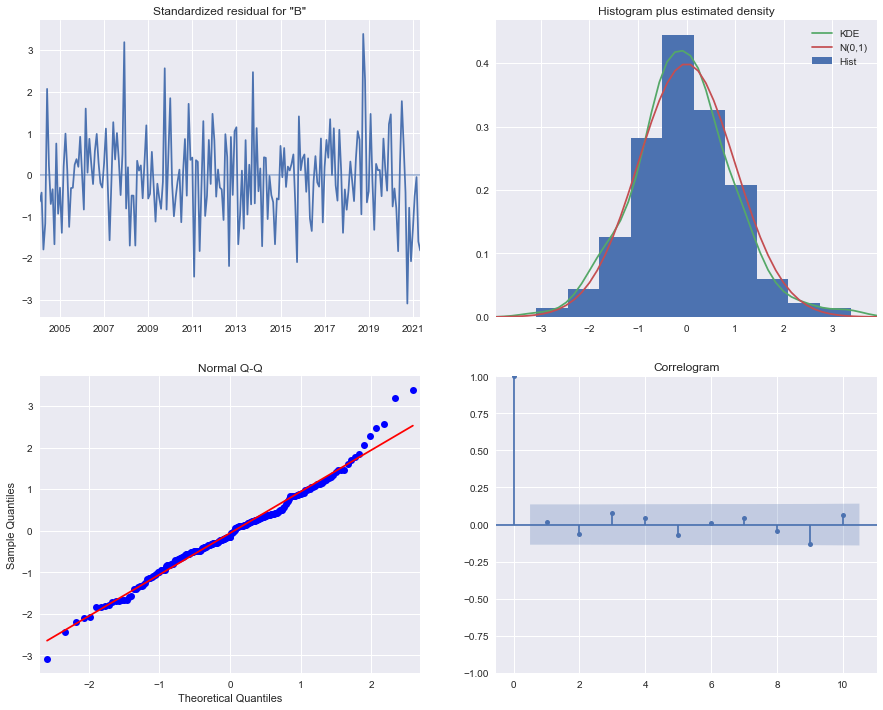

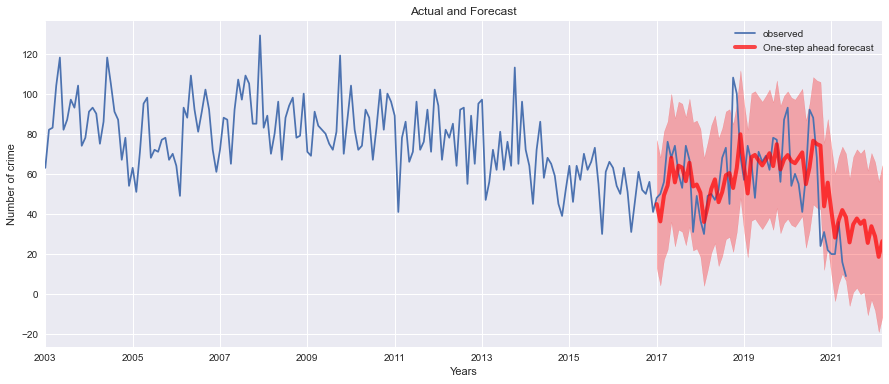

Training for: ASSAULT WITH INJURY
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


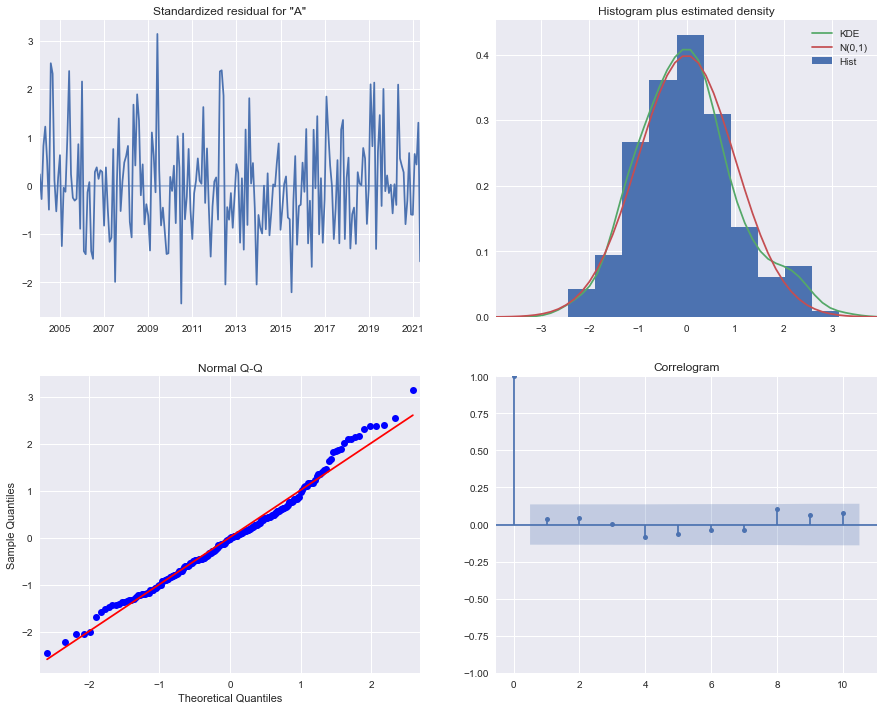

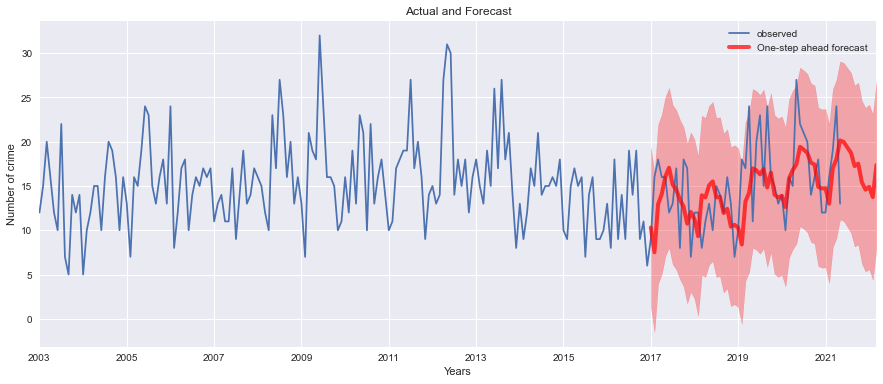

Training for: AUTO THEFT
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


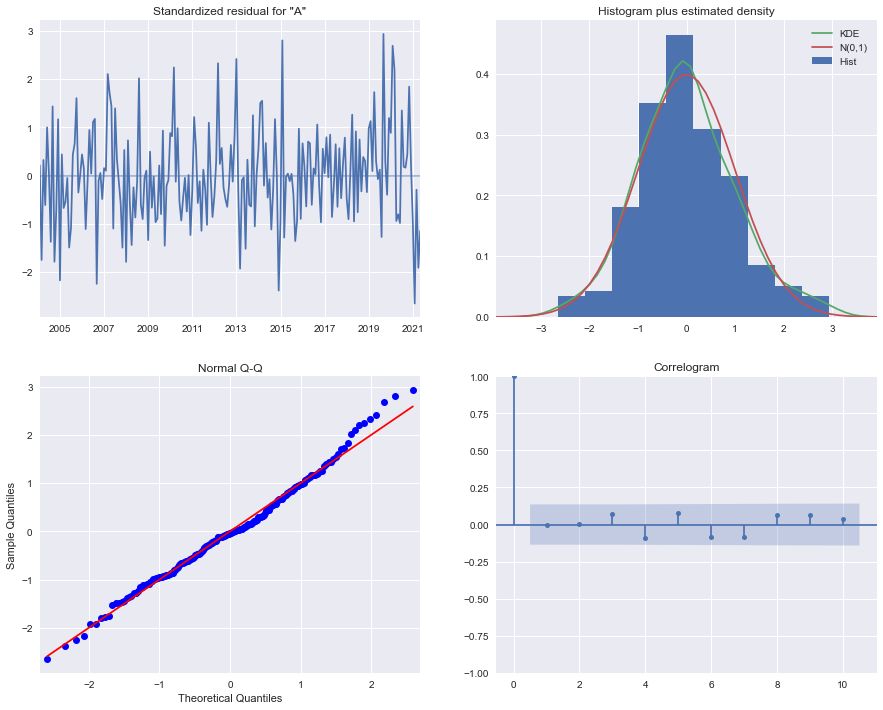

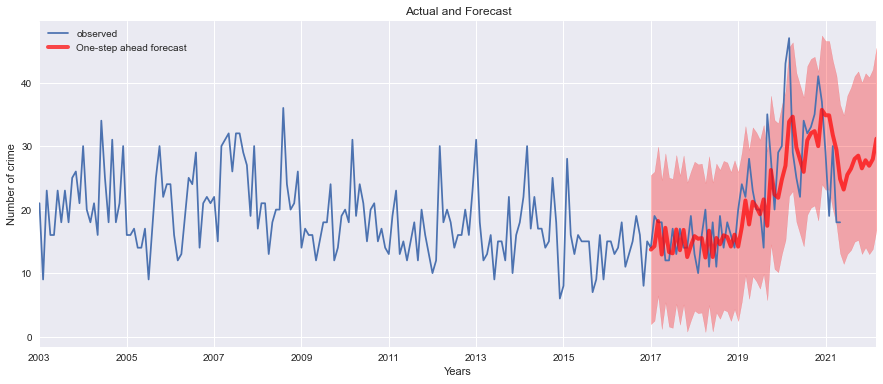

Training for: DWI
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


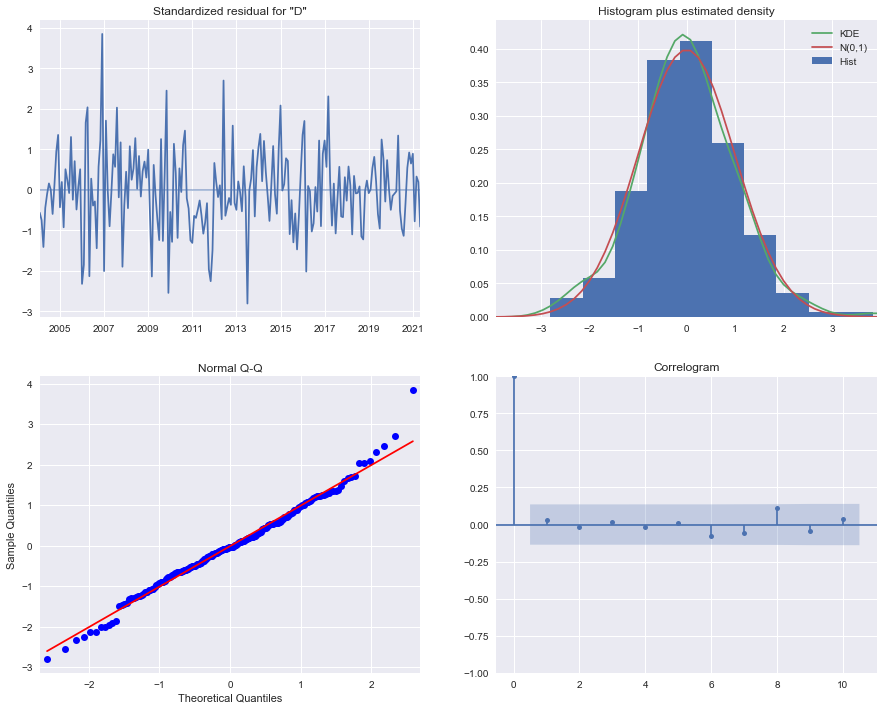

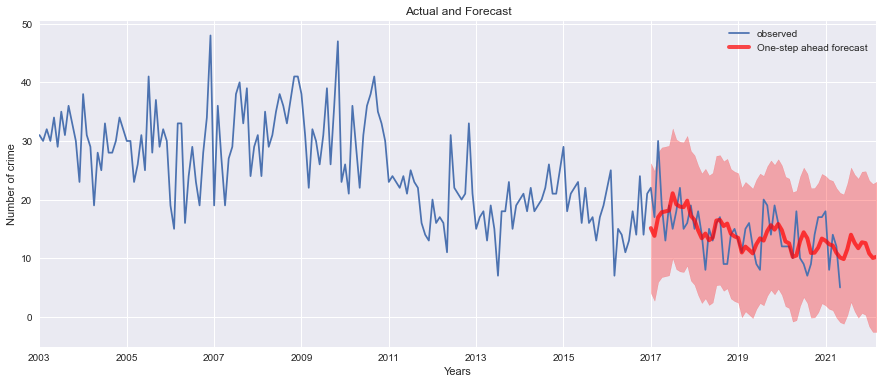

Training for: THEFT BY SHOPLIFTING
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


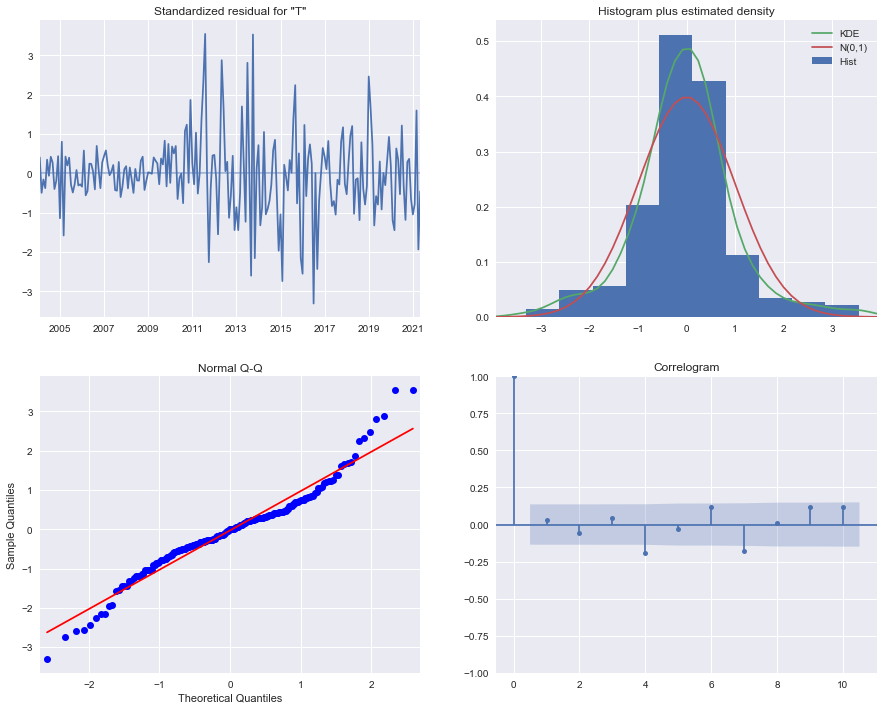

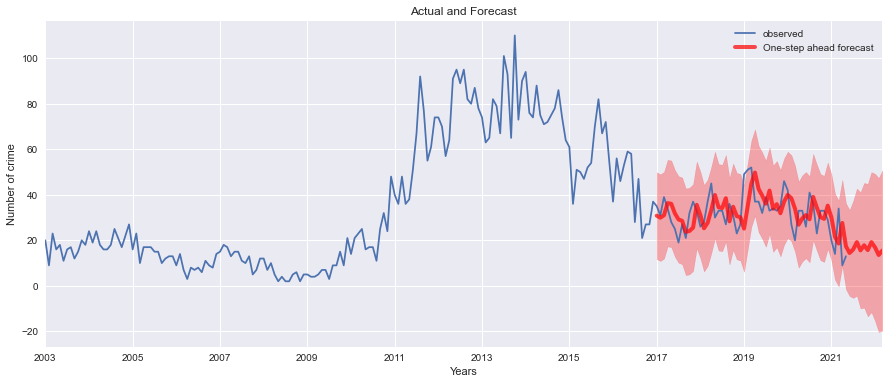

Training for: CRIMINAL TRESPASS
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


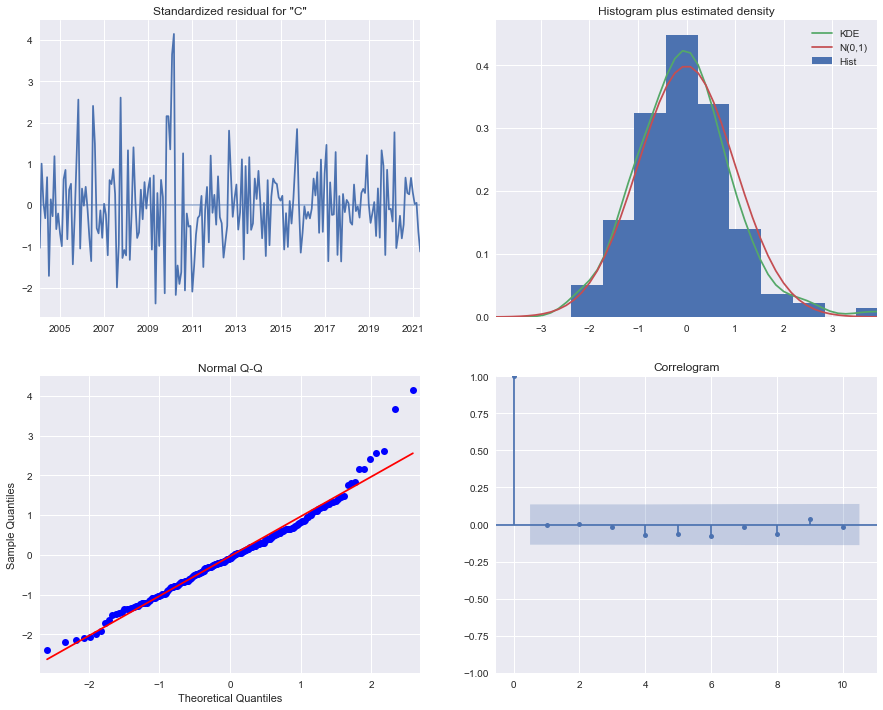

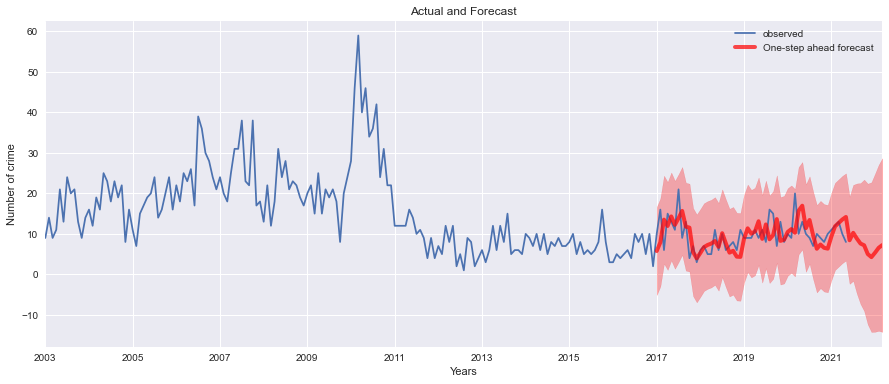

Training for: TOTAL
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


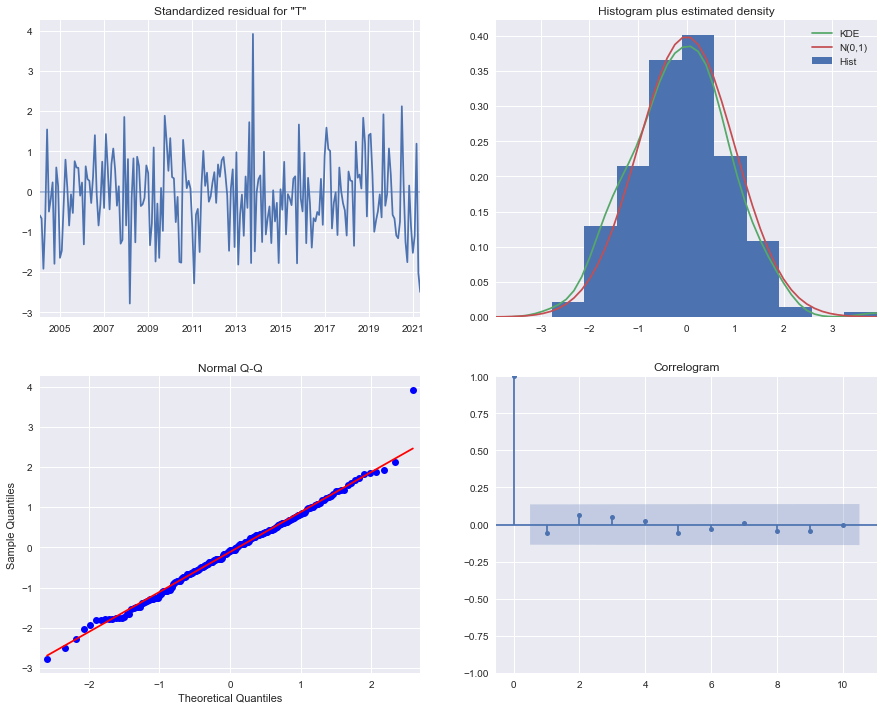

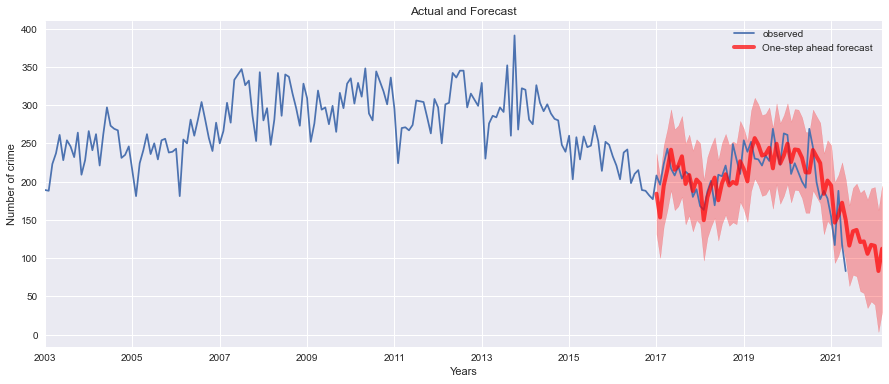

In [11]:
results = []
for i in crimeType:
    results.append(myArima(monthly[i]))

In [12]:
predictions = []
for i in range(0, len(results)):
    predictions.append(
        results[i].get_prediction(start=204, end=230, dynamic=False).predicted_mean
    )

In [13]:
# Calculating MAPE error
predictions = pd.DataFrame(predictions)
predictions = predictions.transpose()
predictions.columns = monthly.columns
errors = (monthly - predictions) / monthly
errors.dropna(how="all", inplace=True)
n = len(errors)

MAPE = round((errors.abs().sum() / n) * 100, 2)
print(
    "The Mean Absolute Percentage Error for each type for the year 01/2020 to 12/2021"
)
display(MAPE)

The Mean Absolute Percentage Error for each type for the year 01/2020 to 12/2021


THEFT                   24.19
BURGLARY OF VEHICLE     73.91
ASSAULT WITH INJURY     18.17
AUTO THEFT              25.12
DWI                     33.00
THEFT BY SHOPLIFTING    40.21
CRIMINAL TRESPASS       29.79
TOTAL                   19.82
dtype: float64

In [14]:
# Formulating the confidence interval
predictions_ci = []
for i in range(0, len(results)):
    predictions_ci.append(
        results[i].get_prediction(start=204, end=230, dynamic=False).conf_int()
    )

# display(predictions_ci)

# Building a forecast table
def forecastMonth(year_month):
    for i in range(0, 9):
        pred_df = round(predictions.iloc[:, i : i + 1][year_month], 0)
        ci_df = round(predictions_ci[i][year_month], 0)
        ci_df.columns = ["Lower CI", "Upper CI"]
        frames = (pred_df, ci_df)
        display(pd.concat(frames, axis=1))


forecastMonth("2021-05")

THEFT  Lower CI  Upper CI
2021-05-31   38.0      13.0      63.0

BURGLARY OF VEHICLE  Lower CI  Upper CI
2021-05-31                 38.0       7.0      70.0

ASSAULT WITH INJURY  Lower CI  Upper CI
2021-05-31                 20.0      11.0      29.0

AUTO THEFT  Lower CI  Upper CI
2021-05-31        25.0      13.0      37.0

DWI  Lower CI  Upper CI
2021-05-31  10.0      -1.0      21.0

THEFT BY SHOPLIFTING  Lower CI  Upper CI
2021-05-31                  17.0      -1.0      36.0

CRIMINAL TRESPASS  Lower CI  Upper CI
2021-05-31               14.0       3.0      25.0

TOTAL  Lower CI  Upper CI
2021-05-31  150.0      97.0     203.0

IndexError: list index out of range

## Predicting crime rates with Facebook Prophet 

### Modeling the data as-is

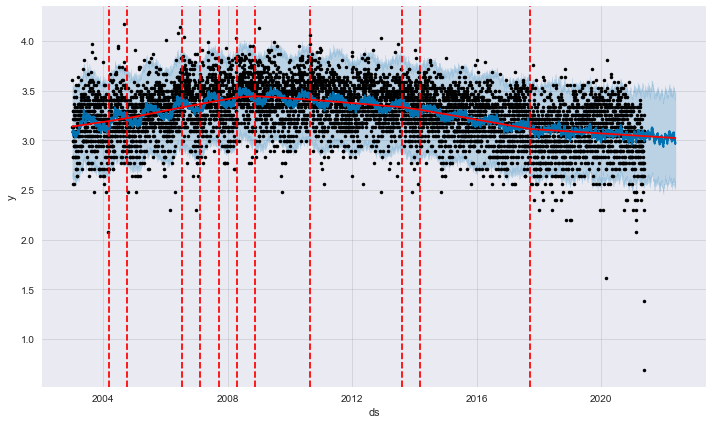

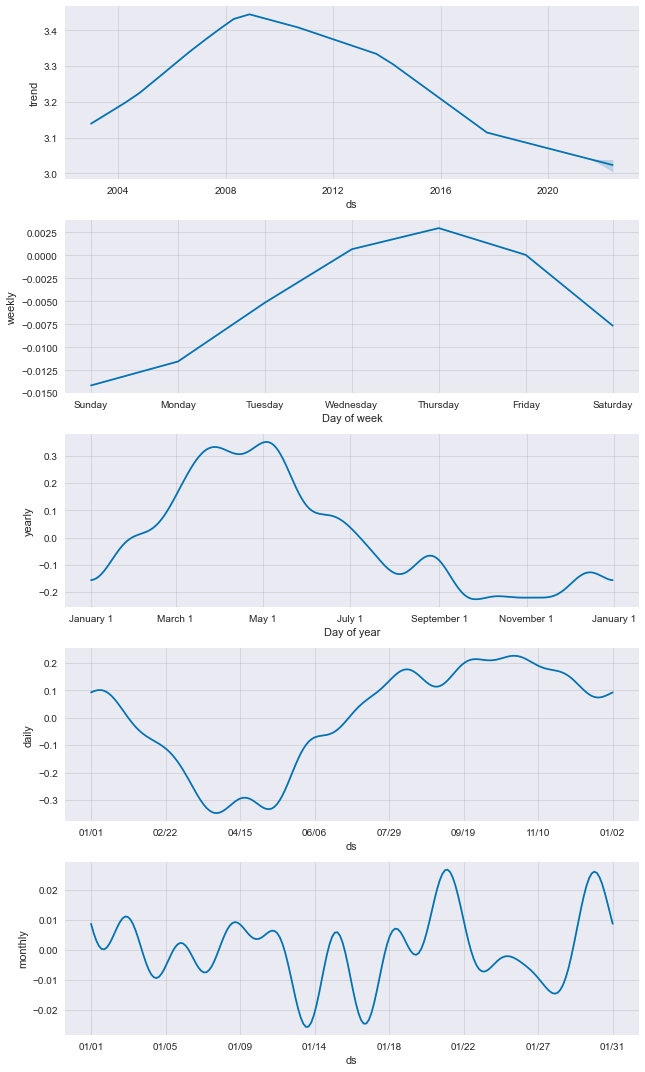

In [22]:
# Prepping to forecast
df_fbprophet = df.copy()
df_m = df_fbprophet.resample("D").size().reset_index()
df_m.columns = ["date", "daily_crime_count"]
df_m_final = df_m.rename(columns={"date": "ds", "daily_crime_count": "y"})
df_m_final["y"] = np.log(df_m_final["y"])
# df_m_final["y"] = pd.to_numeric(df_m_final["y"])
y = df_m_final["y"].to_frame()
y.index = df_m_final["ds"]
n = np.int(y.count())

# Fitting and configuring the model
m = Prophet(interval_width=0.95)
m.add_seasonality(name="monthly", period=30.5, fourier_order=10)
m.add_seasonality(name="weekly", period=52, fourier_order=10)
m.add_seasonality(name="daily", period=366, fourier_order=10)
m.fit(df_m_final)

future = m.make_future_dataframe(periods=366, freq="D")

forecast = m.predict(future)

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

fig2 = m.plot_components(forecast)

fig2_1 = plot_plotly(m, forecast)
fig2_1

In [23]:
help(Prophet)

Help on class Prophet in module fbprophet.forecaster:

class Prophet(builtins.object)
 |  Prophet(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None)
 |  
 |  Prophet forecaster.
 |  
 |  Parameters
 |  ----------
 |  growth: String 'linear' or 'logistic' to specify a linear or logistic
 |      trend.
 |  changepoints: List of dates at which to include potential changepoints. If
 |      not specified, potential changepoints are selected automatically.
 |  n_changepoints: Number of potential changepoints to include. Not used
 |      if input `changepoints` is supplied. If `changepoints` is not supplied,
 |      then n_changepoints potential changepoints are selected uniforml

In [24]:
# The forecast is 'log transformed', so we need to 'inverse' it back by using the exp
forecast_df_exp = np.exp(forecast[["yhat", "yhat_lower", "yhat_upper"]])
forecast_df_exp.index = forecast["ds"]

# Calculating MAPE error 
error = forecast_df_exp["yhat"] - y["y"]
MAPE_df = (error / y["y"]).abs().sum() / n * 100
round(MAPE_df, 2)

708.59

### Mitigating outlier effects on moodel accuracy 

In [25]:
# Make another copy of the data frame as m2
df_prophet2 = df_m_final.copy()

# Define the Upper Control Limit and Lower Control Limit as 3 standard deviations from the mean
ucl = df_prophet2.mean() + df_prophet2.std() * 3
lcl = df_prophet2.mean() - df_prophet2.std() * 3

# display the number of outliers found
print(
    "Above 3 standard deviations: ",
    df_prophet2[df_prophet2["y"] > ucl["y"]]["y"].count(),
    "entries",
)
print(
    "Below 3 standard deviations: ",
    df_prophet2[df_prophet2["y"] < lcl["y"]]["y"].count(),
    "entries",
)

Above 3 standard deviations:  4 entries
Below 3 standard deviations:  29 entries


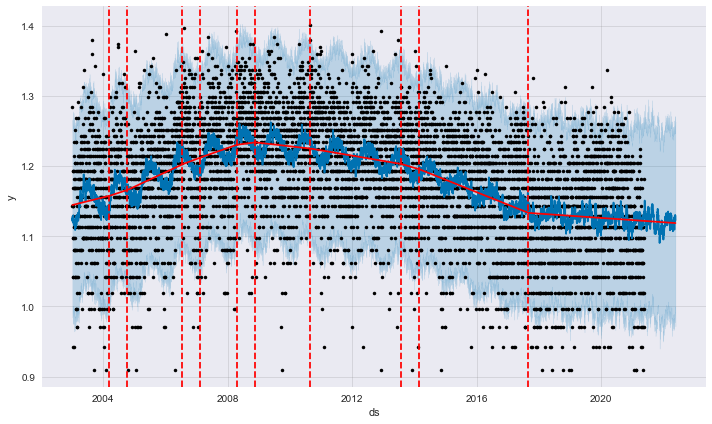

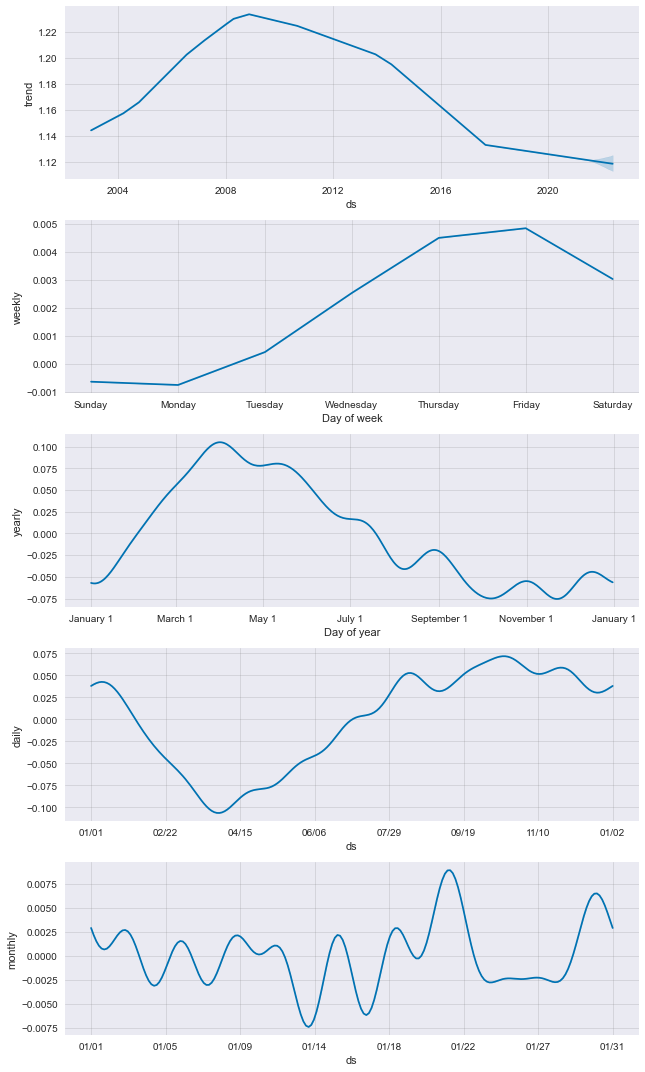

In [26]:
# Remove them by setting their value to None. Prophet says it can handle null values.
df_prophet2.loc[df_prophet2["y"] > ucl["y"], "y"] = None
df_prophet2.loc[df_prophet2["y"] < lcl["y"], "y"] = None

# Log transformation
df_prophet2["y"] = np.log(df_prophet2["y"])
# df_prophet2["y"] = pd.to_numeric(df_prophet2["y"])

# Run Prophet using model 2
m2 = Prophet(interval_width=0.95)
m2.add_seasonality(name="monthly", period=30.5, fourier_order=10)
m2.add_seasonality(name="weekly", period=52, fourier_order=10)
m2.add_seasonality(name="daily", period=366, fourier_order=10)
m2.fit(df_prophet2)

future = m2.make_future_dataframe(periods=366)

forecast_m2 = m2.predict(future)

fig_m2 = m2.plot(forecast_m2)
a = add_changepoints_to_plot(fig_m2.gca(), m2, forecast_m2)

fig2m2 = m2.plot_components(forecast_m2)

fig2_1m2 = plot_plotly(m2, forecast_m2)
fig2_1m2

In [27]:
# Re-inversing the forecast
forecast_m2_exp = np.exp(forecast_m2[["yhat", "yhat_lower", "yhat_upper"]])
forecast_m2_exp.index = forecast_m2["ds"]

# RecalculatinG MAPE error
error = forecast_m2_exp["yhat"] - y["y"]
MAPE_m2 = (error / y["y"]).abs().sum() / n * 100
round(MAPE_m2, 2)

5.74

  0%|          | 0/4 [00:00<?, ?it/s]

  horizon       mse      rmse       mae      mape     mdape  coverage
0 36 days  0.005324  0.072967  0.059798  0.052527  0.048884  0.930070
1 37 days  0.005355  0.073176  0.059888  0.052711  0.048940  0.930070
2 38 days  0.005202  0.072128  0.058522  0.051529  0.048042  0.930070
3 39 days  0.005113  0.071503  0.058216  0.051419  0.047016  0.937063
4 40 days  0.005086  0.071314  0.057486  0.050739  0.046239  0.937063


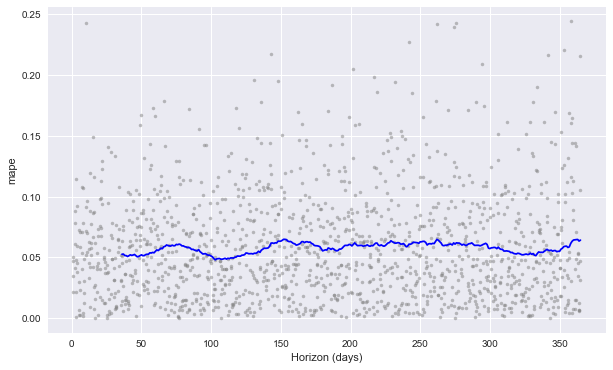

In [28]:
# Doing a diagnostic and performance metrics check visualizing the results 

b = cross_validation(m2, initial="5110 days", period="365 days", horizon="365 days")

p = performance_metrics(b)
print(p.head())

fig4 = plot_cross_validation_metric(b, metric="mape")